# Import the necessary libraries

In [1]:
#Ref https://github.com/hkproj/quantization-notes/tree/main
#Ref https://pytorch.org/docs/stable/quantization-support.html
import torch
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from pathlib import Path
import os
import numpy as np

# Utility Functions

In [2]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    model_size = os.path.getsize("temp.p")/1e3
    print('Size (KB):', model_size)
    os.remove('temp.p')
    return model_size

# Load the MNIST dataset

In [3]:
# Make torch deterministic
_ = torch.manual_seed(0)

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a dataloader for the training
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

# Load the MNIST test set
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=True)

# Define the device
device = "cpu"

# Define the non-quantized model

In [5]:
class QuantizedFCNN(nn.Module):
    def __init__(self, input_size=28*28, hidden_size_1=100, hidden_size_2=100, output_size=10):
        super(QuantizedFCNN,self).__init__()
        self.quant = torch.quantization.QuantStub() #Quantize stub module, before calibration, this is same as an observer,
        self.linear1 = nn.Linear(input_size, hidden_size_1) 
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2) 
        self.linear3 = nn.Linear(hidden_size_2, output_size)
        self.relu = nn.ReLU()
        self.dequant = torch.quantization.DeQuantStub() #Dequantize stub module, before calibration

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.quant(x)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        x = self.dequant(x)
        return x

# Hyperparameters and setting the model

In [6]:
# Hyperparameters
input_size = 28 * 28  # MNIST image size
hidden_size_1 = 100
hidden_size_2 = 100
output_size = 10
batch_size = 10
learning_rate = 0.001
num_epochs = 1

In [7]:
model = QuantizedFCNN(input_size, hidden_size_1, hidden_size_2, output_size).to(device)

# Insert min-max observers in the model

In [8]:
model.qconfig = torch.ao.quantization.default_qconfig # Default qconfig configuration.
model.train()
modelq = torch.ao.quantization.prepare_qat(model) # Do quantization aware training and output a quantized model
modelq

QuantizedFCNN(
  (quant): QuantStub(
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (linear1): Linear(
    in_features=784, out_features=100, bias=True
    (weight_fake_quant): MinMaxObserver(min_val=inf, max_val=-inf)
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (linear2): Linear(
    in_features=100, out_features=100, bias=True
    (weight_fake_quant): MinMaxObserver(min_val=inf, max_val=-inf)
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (linear3): Linear(
    in_features=100, out_features=10, bias=True
    (weight_fake_quant): MinMaxObserver(min_val=inf, max_val=-inf)
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (relu): ReLU()
  (dequant): DeQuantStub()
)

# Train the model

In [9]:
def train(train_loader, model, epochs=5):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            
            if (i+1) % 500 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
            
            loss.backward()
            optimizer.step()
           

In [10]:
train(train_loader, modelq, epochs=num_epochs)

Epoch [1/1], Step [500/6000], Loss: 0.3148
Epoch [1/1], Step [1000/6000], Loss: 0.0154
Epoch [1/1], Step [1500/6000], Loss: 0.4942
Epoch [1/1], Step [2000/6000], Loss: 0.3099
Epoch [1/1], Step [2500/6000], Loss: 0.0246
Epoch [1/1], Step [3000/6000], Loss: 0.1396
Epoch [1/1], Step [3500/6000], Loss: 0.3697
Epoch [1/1], Step [4000/6000], Loss: 0.0030
Epoch [1/1], Step [4500/6000], Loss: 0.2611
Epoch [1/1], Step [5000/6000], Loss: 0.0570
Epoch [1/1], Step [5500/6000], Loss: 0.0118
Epoch [1/1], Step [6000/6000], Loss: 0.0445


In [11]:
def test(test_loader,model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for idx, i in enumerate(outputs):
                if torch.argmax(i) == labels[idx]:
                    correct +=1
                total +=1
                
    print(f'Accuracy: {round(correct/total, 3)}')

# Check the collected statistics during training

In [12]:
print(f'Check the statistics of the various layers')
modelq

Check the statistics of the various layers


QuantizedFCNN(
  (quant): QuantStub(
    (activation_post_process): MinMaxObserver(min_val=-0.4242129623889923, max_val=2.821486711502075)
  )
  (linear1): Linear(
    in_features=784, out_features=100, bias=True
    (weight_fake_quant): MinMaxObserver(min_val=-0.5318018198013306, max_val=0.3377061188220978)
    (activation_post_process): MinMaxObserver(min_val=-41.31510925292969, max_val=37.93396759033203)
  )
  (linear2): Linear(
    in_features=100, out_features=100, bias=True
    (weight_fake_quant): MinMaxObserver(min_val=-0.44693854451179504, max_val=0.34002432227134705)
    (activation_post_process): MinMaxObserver(min_val=-39.279144287109375, max_val=20.906049728393555)
  )
  (linear3): Linear(
    in_features=100, out_features=10, bias=True
    (weight_fake_quant): MinMaxObserver(min_val=-0.4316416084766388, max_val=0.2085840106010437)
    (activation_post_process): MinMaxObserver(min_val=-33.121334075927734, max_val=22.81952667236328)
  )
  (relu): ReLU()
  (dequant): DeQuant

# Quantize the model using the statistics collected

In [13]:
modelq.eval()
modelq = torch.ao.quantization.convert(modelq) # Quantize the model

In [14]:
print(f'Check statistics of the various layers')
modelq

Check statistics of the various layers


QuantizedFCNN(
  (quant): Quantize(scale=tensor([0.0256]), zero_point=tensor([17]), dtype=torch.quint8)
  (linear1): QuantizedLinear(in_features=784, out_features=100, scale=0.6240084767341614, zero_point=66, qscheme=torch.per_tensor_affine)
  (linear2): QuantizedLinear(in_features=100, out_features=100, scale=0.4738991856575012, zero_point=83, qscheme=torch.per_tensor_affine)
  (linear3): QuantizedLinear(in_features=100, out_features=10, scale=0.44047921895980835, zero_point=75, qscheme=torch.per_tensor_affine)
  (relu): ReLU()
  (dequant): DeQuantize()
)

# Print weights and size of the model after quantization

In [15]:
# Print the weights matrix of the model after quantization
print('Weights after quantization')
print(torch.int_repr(modelq.linear1.weight()))

Weights after quantization
tensor([[ 4,  9, -3,  ..., 10,  5,  5],
        [-7, -5, -4,  ..., -7, -3, -9],
        [-1,  8, -4,  ..., -1,  4,  6],
        ...,
        [ 7,  8,  0,  ..., -1,  3, -5],
        [-2,  0,  8,  ...,  3,  3,  3],
        [ 5,  4,  1,  ...,  9, -2,  2]], dtype=torch.int8)


(array([2.0000e+00, 3.1000e+01, 1.7000e+02, 7.4400e+02, 3.7770e+03,
        2.2796e+04, 4.3806e+04, 6.3720e+03, 6.5900e+02, 4.3000e+01]),
 array([-127. , -106.3,  -85.6,  -64.9,  -44.2,  -23.5,   -2.8,   17.9,
          38.6,   59.3,   80. ]),
 <BarContainer object of 10 artists>)

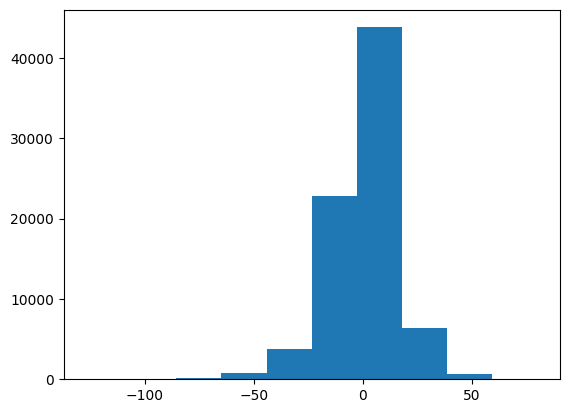

In [16]:
plt.hist(torch.int_repr(modelq.linear1.weight()).cpu().detach().numpy().flatten())

In [17]:
print('Testing the model after quantization')
test(test_loader,modelq)

Testing the model after quantization
Accuracy: 0.952


In [18]:
print('Size of the model after quantization')
modelq_size = print_size_of_model(modelq)

Size of the model after quantization
Size (KB): 95.158
